In [39]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

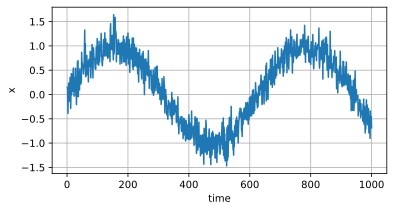

In [40]:
T = 1000 # 总共产生1000个数据点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) # 正弦函数叠加噪声
d2l.plot(time, [x], 'time', 'x', figsize=(6, 3))

In [41]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
    # features按行存储数据
    # 每一行的前tau个时间步的数值作为输入特征
labels = x[tau:].reshape((-1, 1))
# labels是每个时间步的后一个时间步的数值
# 例如：features[0](计入0 - 3)对应的labels是x[tau](x[4])，即features的第一行对应的标签

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [42]:
# 初始化网络权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [43]:
def train(net, train_iter, num_epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss {d2l.evaluate_loss(net, train_iter, loss):f}')

In [44]:
net = get_net()
train(net, train_iter, 10, 0.01)

epoch 1, loss 0.060918
epoch 2, loss 0.054457
epoch 3, loss 0.055208
epoch 4, loss 0.051126
epoch 5, loss 0.051037
epoch 6, loss 0.052193
epoch 7, loss 0.051871
epoch 8, loss 0.050381
epoch 9, loss 0.050441
epoch 10, loss 0.050953


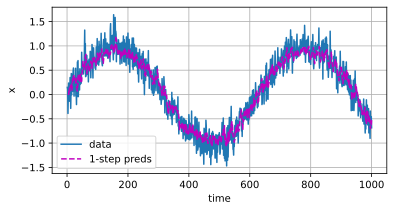

In [45]:
onestep_preds = net(features).detach().numpy()
d2l.plot([time, time[tau:]], [x.numpy(), onestep_preds], xlabel='time', ylabel='x', legend=['data', '1-step preds'], figsize=(6, 3))

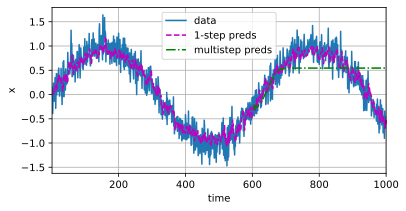

In [46]:
# 数据观察序列的时间步只到n_train + tau(604)
# 我们必须使用我们自己的预测（而不是原始数据）来进行多步预测

multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape(1, -1)).item()

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds,
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

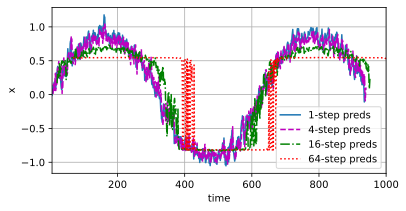

In [47]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))